## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Definitions

In [1]:
import numpy as np
import cv2
import glob
import matplotlib
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None
        self.best_fit_right = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature_left = None 
        self.radius_of_curvature_right = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def update_values(self, left_fit, right_fit, left_curve, right_curve, n):
        if self.radius_of_curvature_left is not None:
            if n > 10:
                n = 10
            self.best_fit_left = ((n - 1) * self.best_fit_left + left_fit) / n
            self.best_fit_right = ((n - 1) * self.best_fit_right + right_fit) / n        

            self.radius_of_curvature_left =  left_curve
            self.radius_of_curvature_right = right_curve
        else:
            self.best_fit_left = left_fit
            self.best_fit_right = right_fit

            self.radius_of_curvature_left =  left_curve
            self.radius_of_curvature_right = right_curve
        return

## This section computes the camera calibration using chessboard images and saves the calibration images.

In [2]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the undistorted image to a file using mtx and dist from above
for fname in images:
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        name_temp = fname.split('/')[-1]
        name = './camera_cal/undistorted/' + name_temp
        cv2.imwrite(name,dst)
        

## This section applies the distortion correction to raw images.

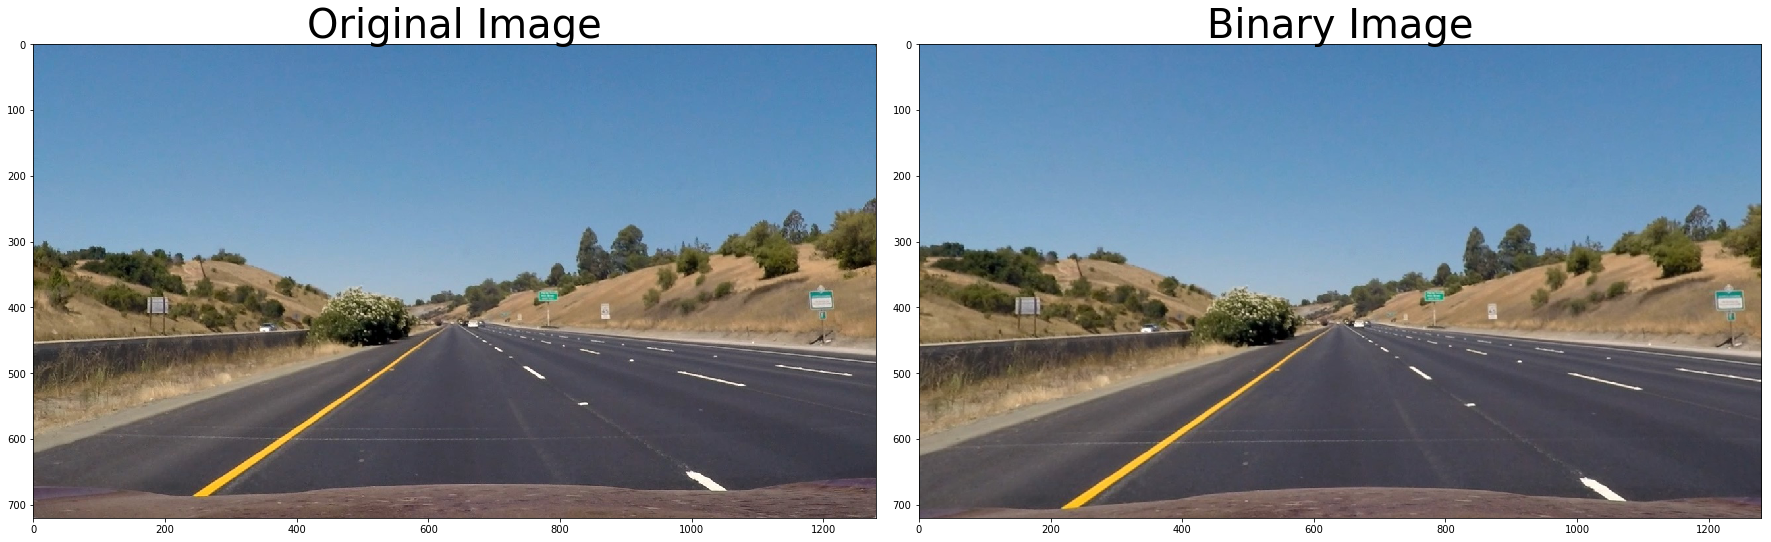

In [3]:
def undistorted (img, mtx=mtx, dist=dist): # This function undistorts the images
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
  
# The following lines perform the distortion correction on the test images from the windshield camera
images = glob.glob('./test_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    undistorted_img = undistorted(img)
    
    name_temp = fname.split('/')[-1]
    name = './test_images/undistorted/' + name_temp
    cv2.imwrite(name,undistorted_img)


    
image = cv2.imread('./test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

image = cv2.imread('./test_images/undistorted/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax2.imshow(image)
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## This section creates the thresholded binary image.

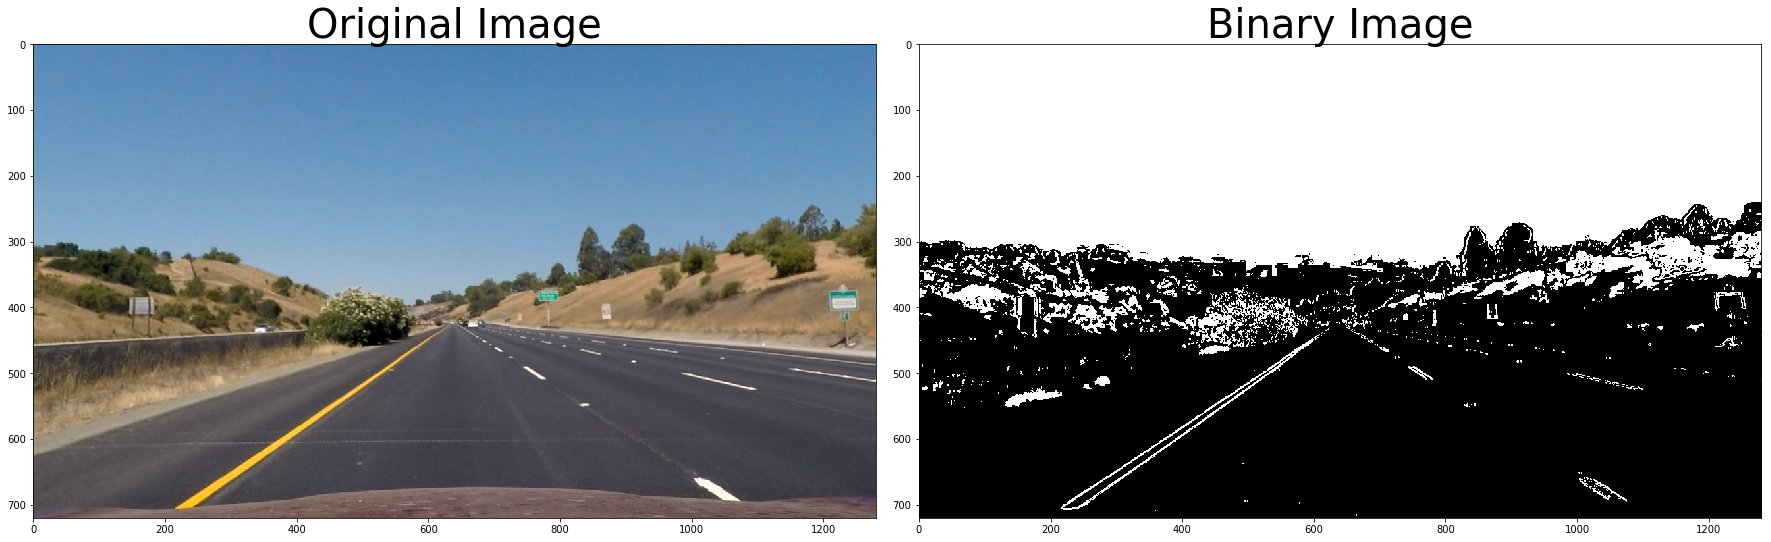

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def thresholded_binary(img, s_thresh=(85, 180), sx_thresh=(40, 200)):
#def thresholded_binary(img, s_thresh=(90, 185), sx_thresh=(70, 200)):    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    #plt.imshow(l_channel)
    s_channel = hsv[:,:,2]
    #plt.figure()
    #plt.imshow(s_channel)
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined = np.zeros_like(color_binary)
    combined[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) 
              | (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
    return combined

# Testing the thresholded_binary function performance
image = cv2.imread('./test_images/undistorted/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = thresholded_binary(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## This section creates the birds-eye view.

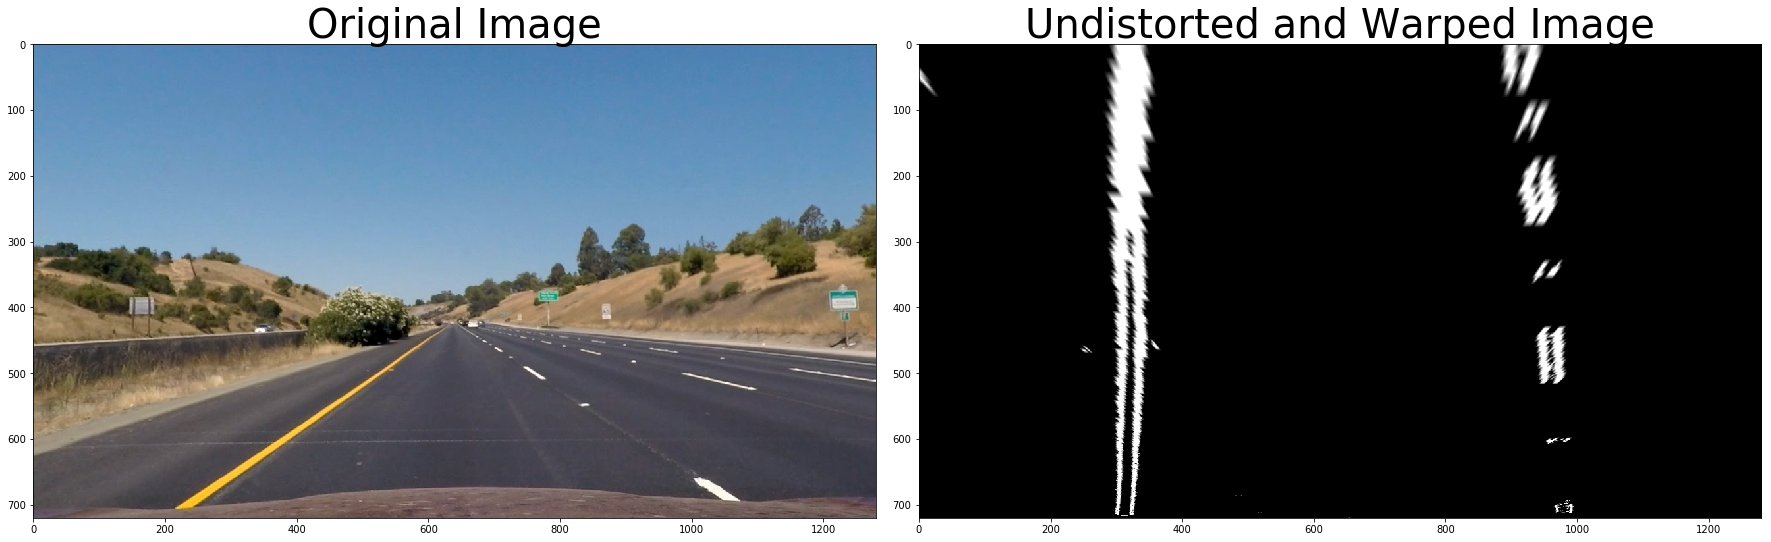

In [62]:
def birdseye (img):
    img_size = img.shape
    src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                    [705. /1280.*img_size[1], 455./720.*img_size[0]],
                    [1130./1280.*img_size[1], 720./720.*img_size[0]],
                    [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    
    dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                    [1000./1280.*img_size[1], 100./720.*img_size[0]],
                    [1000./1280.*img_size[1], 720./720.*img_size[0]],
                    [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
#     src = np.array([[520. /1280.*img_size[1], 500./720.*img_size[0]],
#                     [775. /1280.*img_size[1], 500./720.*img_size[0]],
#                     [1130./1280.*img_size[1], 720./720.*img_size[0]],
#                     [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    
#     dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
#                     [1000./1280.*img_size[1], 100./720.*img_size[0]],
#                     [1000./1280.*img_size[1], 720./720.*img_size[0]],
#                     [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
#     src = np.float32(
#      [[(img_size[1] / 2) - 70, img_size[0] / 2 + 100],
#      [((img_size[1] / 6) - 50), img_size[0]],
#      [(img_size[1] * 5 / 6) + 90, img_size[0]],
#      [(img_size[1] / 2 + 70), img_size[0] / 2 + 100]])
#     dst = np.float32(
#      [[(img_size[1] / 4), 0],
#      [(img_size[1] / 4), img_size[0]],
#      [(img_size[1] * 3 / 4), img_size[0]],
#      [(img_size[1] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


# # Testing the thresholded_binary function performance
# image = cv2.imread('./test_images/undistorted/test5.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# img_size = image.shape
# src_test = np.float32(
#      [[(img_size[1] / 2) - 90, img_size[0] / 2 + 100],
#      [((img_size[1] / 6) - 90), img_size[0]-50],
#      [(img_size[1] * 5 / 6) + 90, img_size[0]-50],
#      [(img_size[1] / 2 + 90), img_size[0] / 2 + 100]])
# dst_test = np.float32(
#      [[(img_size[1] / 4), 0],
#      [(img_size[1] / 4), img_size[0]-50],
#      [(img_size[1] * 3 / 4), img_size[0]],
#      [(img_size[1] * 3 / 4), 0]])

# print (src_test, dst_test)
# src_test = np.array(src_test, np.int32)
# img_test = image
# img_test = cv2.fillPoly(img_test,[src_test],(0,0,0))
# plt.figure()
# plt.imshow(img_test)



# Testing the thresholded_binary function performance
image = cv2.imread('./test_images/undistorted/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = thresholded_binary(image)
result, M_tmp, Minv_tmp = birdseye(result)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Undistorted and Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

## Lane Detection and Fitting + Lane Curvature + Vehicle Location

(720, 0)

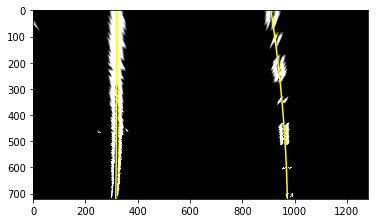

In [131]:
def lane_detection_init (binary_warped):
    histogram = np.sum(binary_warped[int(2*binary_warped.shape[0]/4):,:,0], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = binary_warped*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
#         cv2.imshow('img',out_img)
#         cv2.waitKey(500)
#         cv2.destroyAllWindows()
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit_tmp = np.polyfit(lefty, leftx, 2)
    right_fit_tmp = np.polyfit(righty, rightx, 2)
   
    #Curvature Calculation
    y_eval = binary_warped.shape[0] - 1 
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Vehicle Location
    # delta_x = ((left_fit_cr[-1] + right_fit_cr[-1]) / 2) - (binary_warped.shape[1] * xm_per_pix / 2)
    delta_x = 0
    lane_middle = 0
    lane_middle = ((right_fit_cr[-1] - left_fit_cr[-1]) / 2) + left_fit_cr[-1]
    leng = 3.66/2
    delta_x = (((lane_middle / xm_per_pix)-640)/640.*leng)
    
    return left_fit_tmp, right_fit_tmp, left_curverad, right_curverad, delta_x
    

def lane_detection (binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_tmp = np.polyfit(lefty, leftx, 2)
    right_fit_tmp = np.polyfit(righty, rightx, 2)
    
    #Curvature Calculation
    y_eval = binary_warped.shape[0] - 1 
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Vehicle Location --> Negative means to the left and positive means to the right
    # delta_x = ((left_fit_cr[-1] + right_fit_cr[-1]) / 2) - (binary_warped.shape[1] * xm_per_pix / 2)
    delta_x = 0
    lane_middle = 0
    lane_middle = ((right_fit_cr[-1] - left_fit_cr[-1]) / 2) + left_fit_cr[-1]
    leng = 3.66/2
    delta_x = (((lane_middle / xm_per_pix)-640)/640.*leng)
    return left_fit_tmp, right_fit_tmp, left_curverad, right_curverad, delta_x


# Test the above functions
image = cv2.imread('./test_images/undistorted/straight_lines1.jpg')
result = thresholded_binary(image)
result, M_tmp, Minv_tmp = birdseye(result)    
left_fit, right_fit, left_curve, right_curve, delta_x = lane_detection_init(result)    

# print (left_curve, right_curve, delta_x)

# Generate x and y values for plotting
ploty = np.linspace(0, result.shape[0]-1, result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Sanity Check

In [132]:
def sanity (left_curve, right_curve, lane_previous):
    flag = True
    if (lane_previous.radius_of_curvature_left is not None):
        if (np.abs(left_curve - right_curve) > 1000) and (left_curve < 5000 and right_curve <5000):
            flag = False
        else:
            change_in_curvatre = (((lane_previous.radius_of_curvature_left + lane_previous.radius_of_curvature_left) / 2) 
                                  - ((left_curve + right_curve) / 2)) / ((left_curve + right_curve) / 2)
            if (change_in_curvatre > 0.5):
                flag = False
    else:
        flag = False
    return flag

## Convert the warped image into original image

In [133]:
def update_class (lane_previous, left_fit, right_fit, left_curve, right_curve, n):
#     print ('not updated', lane_previous.radius_of_curvature_left)
    lane_previous.update_values (left_fit, right_fit, left_curve, right_curve, n)
#     print ('updated', lane_previous.radius_of_curvature_left)
    return lane_previous

def unwarped (image, lane_previous, n=50):
    image = undistorted (image)
    image_binary = thresholded_binary(image)#, s_thresh=(185, 255), sx_thresh=(20, 100))
    bird_eye_image, M, Minv = birdseye(image_binary)
    left_fit, right_fit, left_curve, right_curve, delta_x = lane_detection(bird_eye_image)
    
#     print (sanity (left_curve, right_curve, lane_previous), lane_previous.radius_of_curvature_left)
    if sanity (left_curve, right_curve, lane_previous) == True:
        lane_previous = update_class(lane_previous, left_fit, right_fit, left_curve, right_curve, n)
        ploty = np.linspace(300, bird_eye_image.shape[0]-1, bird_eye_image.shape[0] )
        left_fitx = lane_previous.best_fit_left[0]*ploty**2 + lane_previous.best_fit_left[1]*ploty + lane_previous.best_fit_left[2]
        right_fitx = lane_previous.best_fit_right[0]*ploty**2 + lane_previous.best_fit_right[1]*ploty + lane_previous.best_fit_right[2]
    
        warp_zero = np.zeros_like(bird_eye_image).astype(np.uint8)
    
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        text_l = 'Left Curvature = ' + str(float("{0:.2f}".format(left_curve)))
        text_r = 'Left Curvature = ' + str(float("{0:.2f}".format(right_curve)))
        if (delta_x <= 0):
            text_distance = str(abs(float("{0:.2f}".format(delta_x)))) + 'm to Left'
        else:
            text_distance = str(abs(float("{0:.2f}".format(delta_x)))) + 'm to right'
        cv2.putText(result,text_l,(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,text_r,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,text_distance,(50,140), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        return result
    else:
        left_fit, right_fit, left_curve, right_curve, delta_x = lane_detection_init(bird_eye_image)
        lane_previous = update_class(lane_previous, left_fit, right_fit, left_curve, right_curve, n)
        ploty = np.linspace(300, bird_eye_image.shape[0]-1, bird_eye_image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        warp_zero = np.zeros_like(bird_eye_image).astype(np.uint8)
    
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        text_l = 'Left Curvature = ' + str(float("{0:.2f}".format(left_curve)))
        text_r = 'Left Curvature = ' + str(float("{0:.2f}".format(right_curve)))
        if (delta_x <= 0):
            text_distance = str(abs(float("{0:.2f}".format(delta_x)))) + 'm to Left'
        else:
            text_distance = str(abs(float("{0:.2f}".format(delta_x)))) + 'm to right'
        cv2.putText(result,text_l,(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,text_r,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,text_distance,(50,140), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        
        return result
        

def run(image):
    result = unwarped (image, lane_previous)
    return result




In [135]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_previous = Lane()
# image = cv2.imread('./test_images/undistorted/straight_lines2.jpg')
# result = run(image)
# plt.imshow(result)
white_output = 'advanced_lane_finding.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = clip1.subclip(21,23)
# clip1 = clip1.subclip(39,40)
white_clip = clip1.fl_image(run) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video advanced_lane_finding.mp4
[MoviePy] Writing video advanced_lane_finding.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<05:11,  4.05it/s]



  0%|          | 2/1261 [00:00<04:58,  4.21it/s]



  0%|          | 3/1261 [00:00<04:59,  4.19it/s]



  0%|          | 4/1261 [00:00<04:54,  4.27it/s]



  0%|          | 5/1261 [00:01<04:48,  4.35it/s]



  0%|          | 6/1261 [00:01<04:42,  4.45it/s]



  1%|          | 7/1261 [00:01<04:46,  4.38it/s]



  1%|          | 8/1261 [00:01<04:47,  4.35it/s]



  1%|          | 9/1261 [00:02<05:10,  4.03it/s]



  1%|          | 10/1261 [00:02<05:28,  3.80it/s]



  1%|          | 11/1261 [00:02<05:34,  3.73it/s]



  1%|          | 12/1261 [00:02<05:12,  3.99it/s]



  1%|          | 13/1261 [00:03<05:29,  3.79it/s]



  1%|          | 14/1261 [00:03<05:43,  3.63it/s]



  1%|          | 15/1261 [00:03<05:17,  3.93it/s]



  1%|▏         | 16/1261 [00:03<05:09,  4.02it/s]



  1%|▏         | 17/1261 [00:04<04:55,  4.21it/s]



  1%|▏         | 18/1261 [00:04<04:46,  4.33it/s]



  2%|▏ 

[MoviePy] Done.
[MoviePy] >>>> Video ready: advanced_lane_finding.mp4 

CPU times: user 5min 16s, sys: 1min 20s, total: 6min 36s
Wall time: 5min 10s
